# **Fashion MNIST Classification with ANN and CNN Models**
**Overview:**
This code implements and trains deep learning models (Artificial Neural Network and Convolutional Neural Network) to classify images from the Fashion MNIST dataset. It includes model checkpointing, early stopping, and comprehensive evaluation metrics.

**Key Features:**

* Two Model Architectures: ANN and CNN implementations for comparison
* Early Stopping: Prevents overfitting by monitoring validation loss
* Model Checkpointing: Saves the best model weights during training
* Comprehensive Evaluation: Includes confusion matrix and classification metrics
* Reproducibility: Fixed random seeds for consistent results across runs


**Dataset Fashion MNIST:** 70,000 grayscale images (28×28 pixels) of 10 fashion categories

Classes: T-shirt, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot

Train/Test Split: 60,000 training samples and 10,000 test samples
Configuration
Epochs: 10 (with early stopping callback)

Batch Size: 64
Learning Rate: 0.001
Random Seed: 42 (for reproducibility)

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
# New Imports for Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

# CONFIGURATION
RANDOM_SEED = 42
EPOCHS = 10 # Increased epochs since we have EarlyStopping
BATCH_SIZE = 64
LEARNING_RATE = 0.001
TEST_SIZE_VAL = 10000

# Define paths for checkpointing (will save best weights)
ANN_CHECKPOINT_PATH = "ann_best_model.keras"
CNN_CHECKPOINT_PATH = "cnn_best_model.keras"

# Define the 10 class names for analysis and plotting
CLASS_NAMES = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Set seeds for reproducibility
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Define Callbacks for Training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# DATA LOADING & PREPROCESSING  

In this cell we:  
1. **Load Fashion-MNIST** directly from Keras.  
2. **Normalize** pixel intensities to the 0-1 range.  
3. **Reshape** images to (28, 28, 1) so our CNN sees a channel dimension.  
4. **Split** the original 60 k training images into  
   • 50 k for training  
   • 10 k for validation (stratified to keep class balance).  

The console prints the final shapes of the train, validation, and test sets so you can quickly verify everything looks right before modeling.

In [3]:
# DATA LOADING AND PREPROCESSING

print("Data Loading and Preprocessing ")

# Load the dataset
(train_images_full, train_labels_full), (test_images, test_labels) = fashion_mnist.load_data()

# Normalize pixel values to [0.0, 1.0]
train_images_full = train_images_full.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Add channel dimension (28, 28) -> (28, 28, 1) for CNN input
train_images_full = np.expand_dims(train_images_full, -1)
test_images_prepared = np.expand_dims(test_images, -1) # Renamed for clarity

# Split full training set into Training (50,000) and Validation (10,000)
X_train, X_val, y_train, y_val = train_test_split(
    train_images_full,
    train_labels_full,
    test_size=TEST_SIZE_VAL,
    random_state=RANDOM_SEED,
    shuffle=True,
    stratify=train_labels_full
)

print(f"Training Set Size: {X_train.shape}")
print(f"Validation Set Size: {X_val.shape}")
print(f"Test Set Size (Reserved): {test_images_prepared.shape}")

Data Loading and Preprocessing 
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training Set Size: (50000, 28, 28, 1)
Validation Set Size: (10000, 28, 28, 1)
Test Set Size (Reserved): (10000, 28, 28, 1)


#  Model 1 — Fully-Connected ANN (MLP)  

This cell builds and compiles our **baseline dense network** for Fashion-MNIST:

• Architecture  
  1. `Flatten` – turns each 28×28 image into a 784-dim vector  
  2. Dense 256 + ReLU  
  3. `Dropout(0.2)` – regularizes by randomly zeroing 20 % of neurons each step  
  4. Dense 128 + ReLU  
  5. Dense 10 + Softmax – class probabilities  

• Compilation  
  – Optimizer: `Adam` (lr = 0.001)  
  – Loss: `sparse_categorical_crossentropy`  
  – Metric: `accuracy`  

The `model.summary()` call prints layer-by-layer shapes and parameter counts, giving a quick sanity check before training.

In [4]:
# MODEL DEFINITION: ANN (MLP) - Improved with Dropout
def create_ann_model():
    model = Sequential([
        Flatten(input_shape=(28, 28, 1), name='input_flatten'),
        Dense(units=256, activation='relu', name='hidden_1'),
        Dropout(rate=0.2, name='ann_dropout'), # Added Dropout for regularization
        Dense(units=128, activation='relu', name='hidden_2'),
        Dense(units=10, activation='softmax', name='output')
    ], name='ANN_MLP_Model')
    return model

ann_model = create_ann_model()
ann_model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


ann_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "ANN_MLP_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_flatten (Flatten)         │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_1 (Dense)                │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ ann_dropout (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

#  Model 2 — Convolutional Neural Network (CNN)  

A deeper CNN tailored for 28×28 Fashion-MNIST images:

• Feature Extractor  
  1. Conv 32 + ReLU → MaxPool  
  2. Conv 64 + ReLU → MaxPool  
  3. Conv 128 + ReLU → MaxPool  

• Classifier  
  – `Flatten` → Dense 128 + ReLU → `Dropout(0.5)`  
  – Dense 10 + Softmax for class probabilities  

Compiled with `Adam (lr = 0.001)`, `sparse_categorical_crossentropy`, and accuracy tracking.  
The summary call at the end prints layer shapes & parameter counts.

In [5]:
# MODEL DEFINITION: CNN - Improved with Deeper Blocks

def create_cnn_model():
    model = Sequential([
        # Block 1
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), padding='same', name='conv_1'),
        MaxPooling2D((2, 2), name='pool_1'),

        # Block 2
        Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_2'),
        MaxPooling2D((2, 2), name='pool_2'),

        # Block 3 (Deeper Layer for better feature extraction)
        Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_3'),
        MaxPooling2D((2, 2), name='pool_3'),

        # Classification Head
        Flatten(name='flatten'),
        Dense(128, activation='relu', name='dense_1'),
        Dropout(rate=0.5, name='dropout'),
        Dense(10, activation='softmax', name='output')
    ], name='CNN_Model')
    return model

cnn_model = create_cnn_model()
cnn_model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cnn_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_3 (MaxPooling2D)           │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,546 (943.54 KB)

 Trainable params: 241,546 (943.54 KB)

 Non-trainable params: 0 (0.00 B)

#  Training Time — with Early Stopping & Checkpointing  

In this cell we actually *teach* the networks:

1. **Callbacks**  
   • `EarlyStopping` – halts training when validation loss hasn’t improved for 5 epochs (and automatically rolls back to the best weights).  
   • `ModelCheckpoint` – saves the weights with the lowest `val_loss` for both the ANN and CNN.  

2. **Training Loop**  
   – Starts with the ANN (`ann_model.fit(...)`) using our chosen hyper-parameters.  
   – Progress bars will show epoch-by-epoch accuracy and loss for both training and validation sets.  

3. **Post-training Safety Net**  
   – `load_weights()` reloads the best saved ANN weights from disk to ensure we keep the optimal model snapshot for later evaluation.

(The CNN will be trained in a similar fashion right after this.)

In [6]:
# TRAINING - Added Callbacks

print("\n Training Models ")

# Setup Checkpoints
ann_checkpoint = ModelCheckpoint(ANN_CHECKPOINT_PATH, monitor='val_loss', save_best_only=True, verbose=0)
cnn_checkpoint = ModelCheckpoint(CNN_CHECKPOINT_PATH, monitor='val_loss', save_best_only=True, verbose=0)

print("\n Starting ANN Training")
ann_history = ann_model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, ann_checkpoint], # Added callbacks
    verbose=1
)

# After training, load the best weights saved by the checkpoint (redundant if restore_best_weights=True, but good practice)
ann_model.load_weights(ANN_CHECKPOINT_PATH)


 Training Models 

 Starting ANN Training
Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.7551 - loss: 0.6941 - val_accuracy: 0.8630 - val_loss: 0.3856
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8504 - loss: 0.4081 - val_accuracy: 0.8690 - val_loss: 0.3657
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8632 - loss: 0.3671 - val_accuracy: 0.8677 - val_loss: 0.3597
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8703 - loss: 0.3457 - val_accuracy: 0.8708 - val_loss: 0.3505
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8770 - loss: 0.3271 - val_accuracy: 0.8750 - val_loss: 0.3384
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8798 - loss: 0.3140 - val_accuracy: 0.8847 - val_loss: 0.3218
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8869 - loss: 0.3015 - val_accuracy: 0.8849 - val_loss: 0.3178
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accurac

# CNN Training Loop (with Early-Stopping & Checkpoint)  

Exactly like we did for the ANN, but now for the **convolutional model**:

• Trains `cnn_model` for up to 10 epochs (batch = 64).  
• `EarlyStopping` watches `val_loss`, stopping if no improvement for 5 consecutive epochs.  
• `ModelCheckpoint` persistently saves the weights with the lowest validation loss to `cnn_best_model.keras`.  
• After the fit completes, we explicitly reload those best weights to guarantee the model in memory is the top-performing snapshot.  

In [7]:
print("\n Starting CNN Training ")
cnn_history = cnn_model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, cnn_checkpoint], # Added callbacks
    verbose=1
)

# After training, load the best weights
cnn_model.load_weights(CNN_CHECKPOINT_PATH)


 Starting CNN Training 
Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.6702 - loss: 0.9090 - val_accuracy: 0.8660 - val_loss: 0.3729
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8515 - loss: 0.4185 - val_accuracy: 0.8863 - val_loss: 0.3069
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8763 - loss: 0.3434 - val_accuracy: 0.8989 - val_loss: 0.2737
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8884 - loss: 0.3048 - val_accuracy: 0.9091 - val_loss: 0.2505
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9013 - loss: 0.2734 - val_accuracy: 0.9137 - val_loss: 0.2378
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9092 - loss: 0.2547 - val_accuracy: 0.9140 - val_loss: 0.2397
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9143 - loss: 0.2334 - val_accuracy: 0.9181 - val_loss: 0.2260
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9225 - loss

#  Evaluation & Analysis  

Here we measure how both trained models generalize to **unseen data**:

1. `model.evaluate(...)` runs a forward-pass over the 10 k reserved test images, returning **loss** and **accuracy** for:
   • The fully-connected ANN  
   • The Convolutional CNN  

2. We then print the test accuracies side-by-side, giving a quick reality-check of which architecture performs better on real, untouched data.

In [8]:
# EVALUATION AND ANALYSIS

print("\n Evaluation and Analysis ")

# Evaluate final performance on the reserved Test Set
ann_loss, ann_accuracy = ann_model.evaluate(test_images_prepared, test_labels, verbose=0)
cnn_loss, cnn_accuracy = cnn_model.evaluate(test_images_prepared, test_labels, verbose=0)

print(f"\nANN Test Accuracy: {ann_accuracy:.4f}")
print(f"CNN Test Accuracy: {cnn_accuracy:.4f}")


 Evaluation and Analysis 

ANN Test Accuracy: 0.8708
CNN Test Accuracy: 0.9154


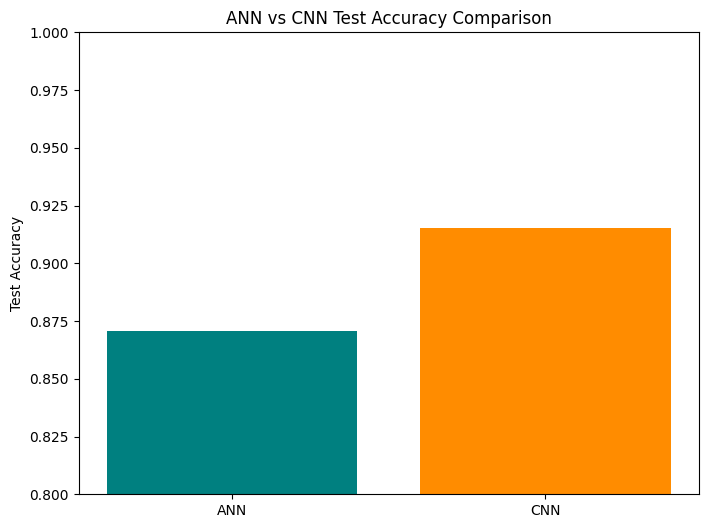

In [13]:
plt.figure(figsize=(8, 6))

plt.bar(models, accuracies, color=['teal', 'darkorange'])

plt.ylim([0.8, 1.0])

plt.ylabel('Test Accuracy')

plt.title('ANN vs CNN Test Accuracy Comparison')

plt.show()

# Predictions & Confusion Matrices  

In this cell we:

1. **Generate class-probability predictions** for the 10 k test images with both models (`model.predict`).  
2. **Convert probabilities → class indices** using `np.argmax`.  
3. **Compute confusion matrices** (`sklearn.metrics.confusion_matrix`) to see, class-by-class, where each model is getting things right or tripping up.

These matrices will fuel the next visualization step (heat-maps) for a deeper error analysis.

In [8]:
# --- Generate Predictions for Confusion Matrix ---
ann_predictions = ann_model.predict(test_images_prepared)
cnn_predictions = cnn_model.predict(test_images_prepared)

ann_predicted_labels = np.argmax(ann_predictions, axis=1)
cnn_predicted_labels = np.argmax(cnn_predictions, axis=1)

ann_cm = confusion_matrix(test_labels, ann_predicted_labels)
cnn_cm = confusion_matrix(test_labels, cnn_predicted_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


# Training Curves — ANN vs CNN  

This cell defines the `plot_history` helper and immediately calls it to:

1. Draw side-by-side line charts of **accuracy** and **loss** for both training and validation sets.  
2. Overlay curves for the ANN (blue) and CNN (red) so you can visually compare learning speed, convergence, and overfitting patterns.  
3. Annotate the figure’s title with each model’s final **test accuracy** for a quick performance snapshot.

A handy one-stop visualization to see which architecture learned better and how stable each training run was over time.

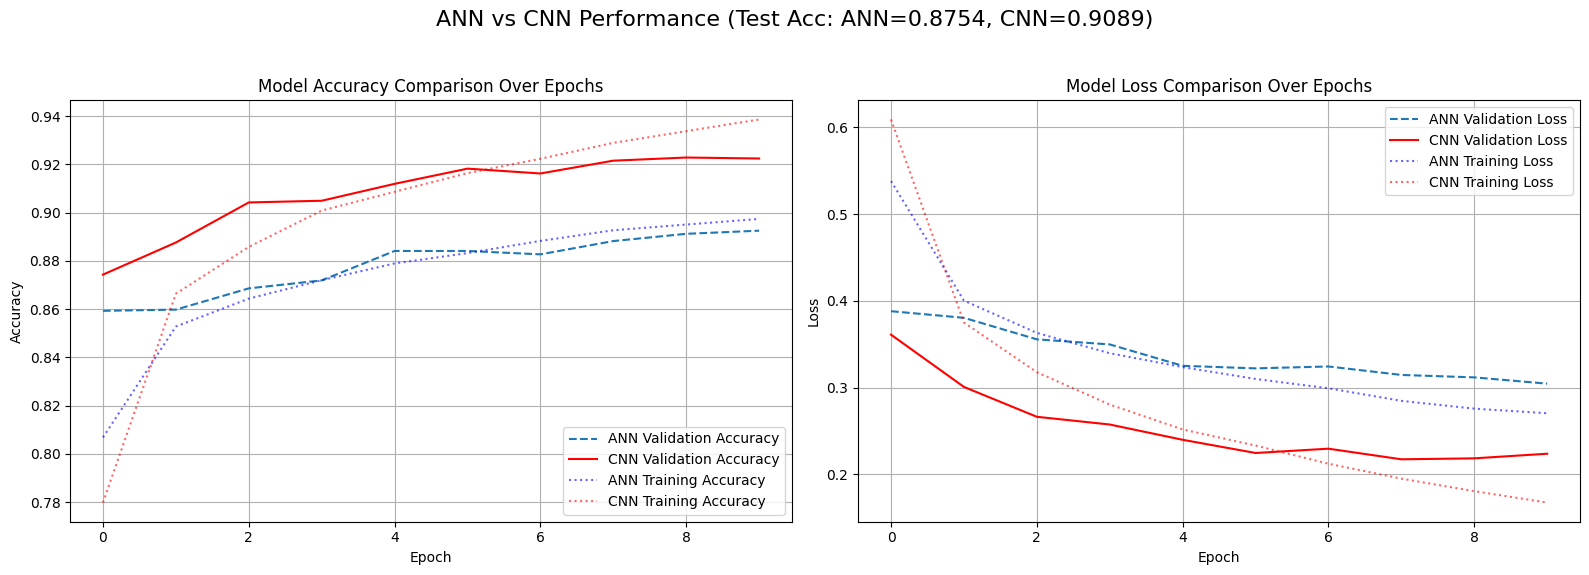

In [9]:
# Plotting Function
def plot_history(ann_hist, cnn_hist):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Accuracy
    axes[0].plot(ann_hist.history['val_accuracy'], label='ANN Validation Accuracy', linestyle='--')
    axes[0].plot(cnn_hist.history['val_accuracy'], label='CNN Validation Accuracy', color='red')
    axes[0].plot(ann_hist.history['accuracy'], label='ANN Training Accuracy', linestyle=':', color='blue', alpha=0.6)
    axes[0].plot(cnn_hist.history['accuracy'], label='CNN Training Accuracy', color='red', linestyle=':', alpha=0.6)
    axes[0].set_title('Model Accuracy Comparison Over Epochs')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend(loc='lower right')
    axes[0].grid(True)

    # Loss
    axes[1].plot(ann_hist.history['val_loss'], label='ANN Validation Loss', linestyle='--')
    axes[1].plot(cnn_hist.history['val_loss'], label='CNN Validation Loss', color='red')
    axes[1].plot(ann_hist.history['loss'], label='ANN Training Loss', linestyle=':', color='blue', alpha=0.6)
    axes[1].plot(cnn_hist.history['loss'], label='CNN Training Loss', color='red', linestyle=':', alpha=0.6)
    axes[1].set_title('Model Loss Comparison Over Epochs')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend(loc='upper right')
    axes[1].grid(True)

    plt.suptitle(f'ANN vs CNN Performance (Test Acc: ANN={ann_accuracy:.4f}, CNN={cnn_accuracy:.4f})', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Run the plotting functions
plot_history(ann_history, cnn_history)


# Confusion-Matrix Visualization Helper  

This utility function wraps seaborn’s `heatmap` so we can:

• Feed in a pre-computed confusion matrix (`cm`).  
• Render a color-coded, annotated grid with **true vs. predicted** class labels (`CLASS_NAMES`).  
• Quickly swap titles to show results for either the ANN or the CNN.

Run it twice (once per model) to pinpoint which Fashion-MNIST categories are being confused the most.

In [10]:
# Plotting Function for Confusion Matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Pastel2',
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.title(f'Confusion Matrix for {title}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

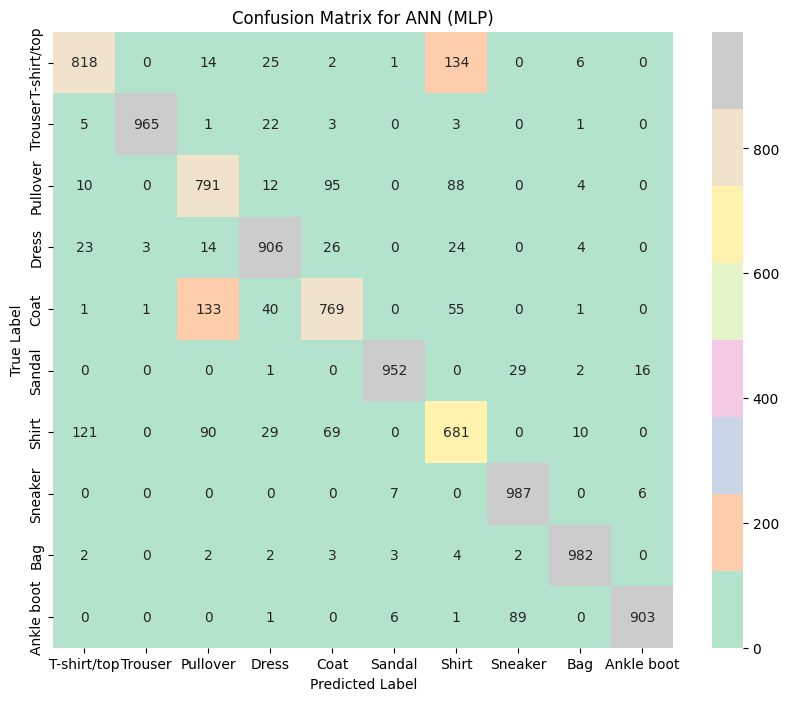

In [11]:
plot_confusion_matrix(ann_cm, 'ANN (MLP)')

#  Confusion Matrix — CNN  

Runs our helper to visualize the CNN’s performance class-by-class:

• Feeds in `cnn_cm`, the confusion matrix built from CNN predictions  
• Produces an annotated heat-map (true label on Y-axis, predicted on X-axis)  
• Lets you instantly spot where the model excels and where it confuses similar fashion items (e.g., *Shirt* vs *T-shirt*).

Execute to see the misclassification patterns in living color!

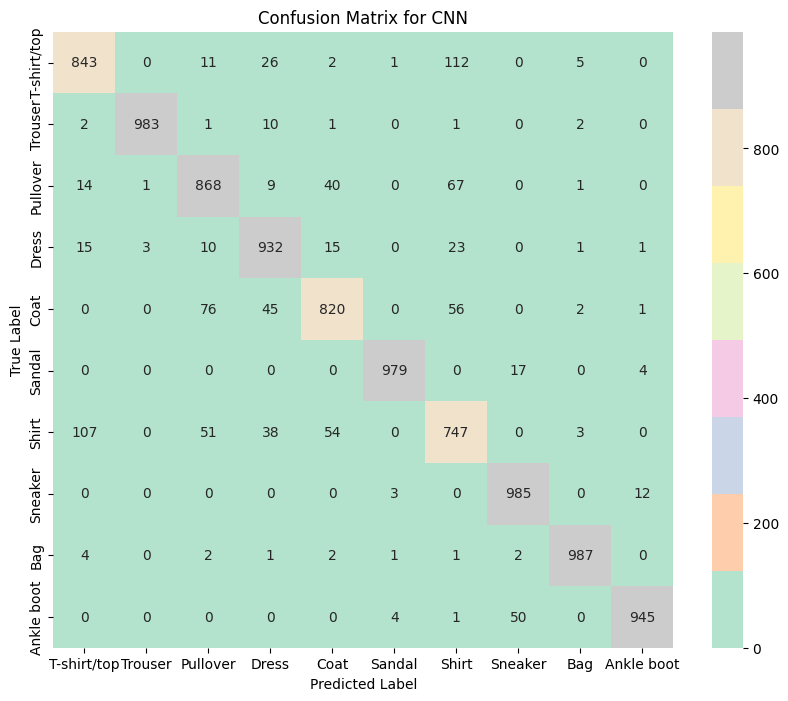

In [12]:
plot_confusion_matrix(cnn_cm, 'CNN')

In [15]:
# --- Generate Predictions for Confusion Matrix ---
ann_predictions = ann_model.predict(test_images_prepared)
cnn_predictions = cnn_model.predict(test_images_prepared)

ann_predicted_labels = np.argmax(ann_predictions, axis=1)
cnn_predicted_labels = np.argmax(cnn_predictions, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [16]:
from sklearn.metrics import classification_report

# Generate classification report for ANN
print("Classification Report for ANN Model:")
print(classification_report(test_labels, ann_predicted_labels, target_names=CLASS_NAMES))

# Generate classification report for CNN
print("\nClassification Report for CNN Model:")
print(classification_report(test_labels, cnn_predicted_labels, target_names=CLASS_NAMES))

Classification Report for ANN Model:
              precision    recall  f1-score   support

 T-shirt/top       0.84      0.82      0.83      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.73      0.84      0.78      1000
       Dress       0.88      0.90      0.89      1000
        Coat       0.79      0.77      0.78      1000
      Sandal       0.96      0.97      0.96      1000
       Shirt       0.72      0.64      0.67      1000
     Sneaker       0.87      0.98      0.92      1000
         Bag       0.97      0.97      0.97      1000
  Ankle boot       0.99      0.85      0.92      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000


Classification Report for CNN Model:
              precision    recall  f1-score   support

 T-shirt/top       0.87      0.85      0.86      1000
     Trouser       0.99      0.98      0.99      1000
   

In [19]:
import pandas as pd

# Parse classification report into a dictionary for ANN
ann_report = classification_report(test_labels, ann_predicted_labels, target_names=CLASS_NAMES, output_dict=True)
ann_metrics_df = pd.DataFrame(ann_report).transpose()

# Parse classification report into a dictionary for CNN
cnn_report = classification_report(test_labels, cnn_predicted_labels, target_names=CLASS_NAMES, output_dict=True)
cnn_metrics_df = pd.DataFrame(cnn_report).transpose()

# Exclude overall averages like 'accuracy', 'macro avg', 'weighted avg' for plotting per class
ann_metrics_per_class = ann_metrics_df.drop(['accuracy', 'macro avg', 'weighted avg'])
cnn_metrics_per_class = cnn_metrics_df.drop(['accuracy', 'macro avg', 'weighted avg'])

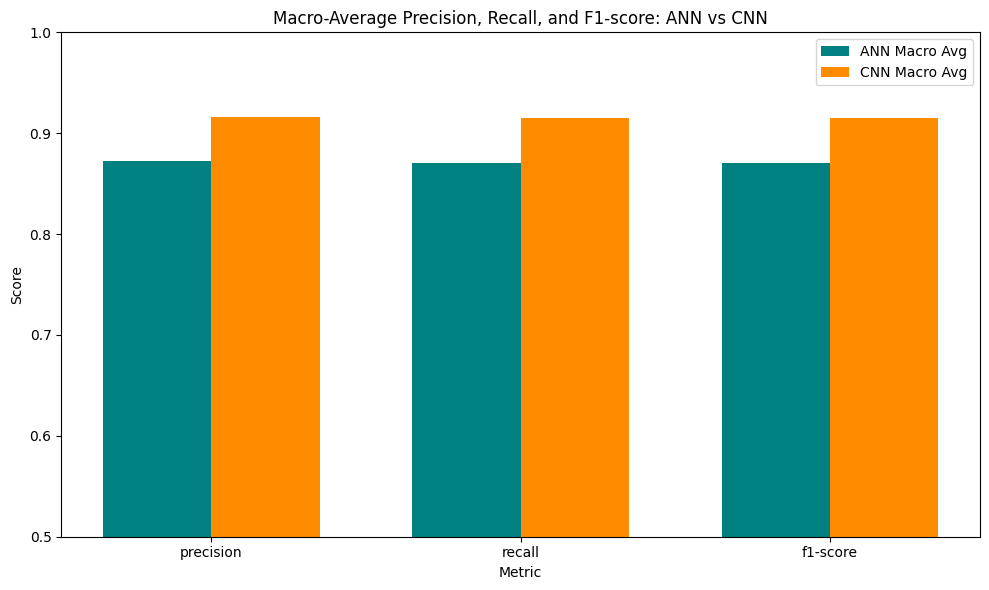

In [23]:
# Extract macro average metrics for plotting
metrics = ['precision', 'recall', 'f1-score']
ann_macro_metrics = [ann_metrics_df.loc['macro avg', metric] for metric in metrics]
cnn_macro_metrics = [cnn_metrics_df.loc['macro avg', metric] for metric in metrics]

# Plotting combined bar graph for macro average metrics
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(metrics))

plt.bar(index, ann_macro_metrics, bar_width, label='ANN Macro Avg', color='teal')
plt.bar(index + bar_width, cnn_macro_metrics, bar_width, label='CNN Macro Avg', color='darkorange')

plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('Macro-Average Precision, Recall, and F1-score: ANN vs CNN')
plt.xticks(index + bar_width / 2, metrics)
plt.ylim([0.5, 1.0])
plt.legend()
plt.tight_layout()
plt.show()

# ANN Sample-Predictions Gallery  

This cell displays **15 random test images** along with the ANN’s prediction:

• Shows each image, the **predicted class**, prediction **confidence (%)**, and the **true label**.  
• Title color: **green** when prediction is correct, **red** when wrong—makes errors pop out visually.  
• Quickly spot which fashion items the dense network nails and which ones trip it up.


 Visualizing 15 ANN Sample Predictions 


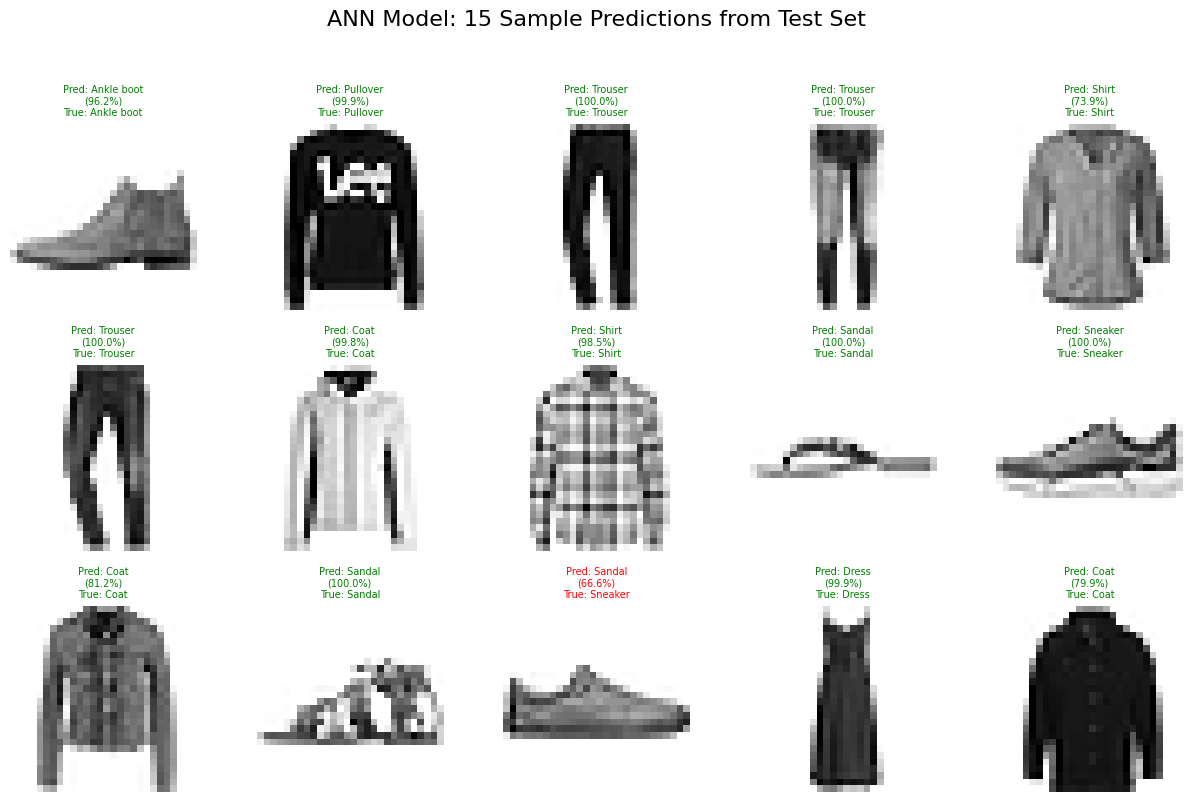

In [13]:
# ANN SAMPLE PREDICTIONS VISUALIZATION

# Define the number of samples to show for visualization
NUM_SAMPLES_TO_SHOW = 15

print(f"\n Visualizing {NUM_SAMPLES_TO_SHOW} ANN Sample Predictions ")

# Determine grid size for subplots
rows = (NUM_SAMPLES_TO_SHOW + 4) // 5
cols = 5

# Layout Setup
# Increased figure size for more space and better text separation
plt.figure(figsize=(cols * 2.5, rows * 2.8))

for i in range(NUM_SAMPLES_TO_SHOW):
    plt.subplot(rows, cols, i + 1)

    # Prepare the single image for prediction
    input_sample = test_images_prepared[i:i+1]

    # Get true label
    true_label_index = test_labels[i]
    true_label_name = CLASS_NAMES[true_label_index]

    # ANN Prediction
    ann_pred_probs = ann_model.predict(input_sample, verbose=0)[0]
    ann_predicted_index = np.argmax(ann_pred_probs)
    ann_predicted_name = CLASS_NAMES[ann_predicted_index]
    ann_confidence = ann_pred_probs[ann_predicted_index] * 100

    # Display the image
    plt.imshow(test_images[i], cmap=plt.cm.binary)
    plt.axis('off')

    # Set title with prediction, confidence, and true label
    color = "green" if ann_predicted_index == true_label_index else "red"
    title_text = f"Pred: {ann_predicted_name}\n({ann_confidence:.1f}%)\nTrue: {true_label_name}"

    # Reduced font size and added color for readability
    plt.title(title_text, color=color, fontsize=7)

# Final Layout Adjustments
plt.suptitle(f'ANN Model: {NUM_SAMPLES_TO_SHOW} Sample Predictions from Test Set', fontsize=16)
plt.subplots_adjust(wspace=0.3, hspace=0.6) # Increased horizontal and vertical space between subplots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#  CNN Sample-Predictions Gallery  

A quick, visual sanity-check for our convolutional model:

• Displays **15 test images** in a single figure.  
• Each tile shows:  
  – **Predicted class** + confidence (%)  
  – **True label**  
• Title color: **green** = correct, **red** = misclassified.  

Great for spotting patterns in the CNN’s successes and slip-ups at a glance.


 Visualizing 15 CNN Sample Predictions 


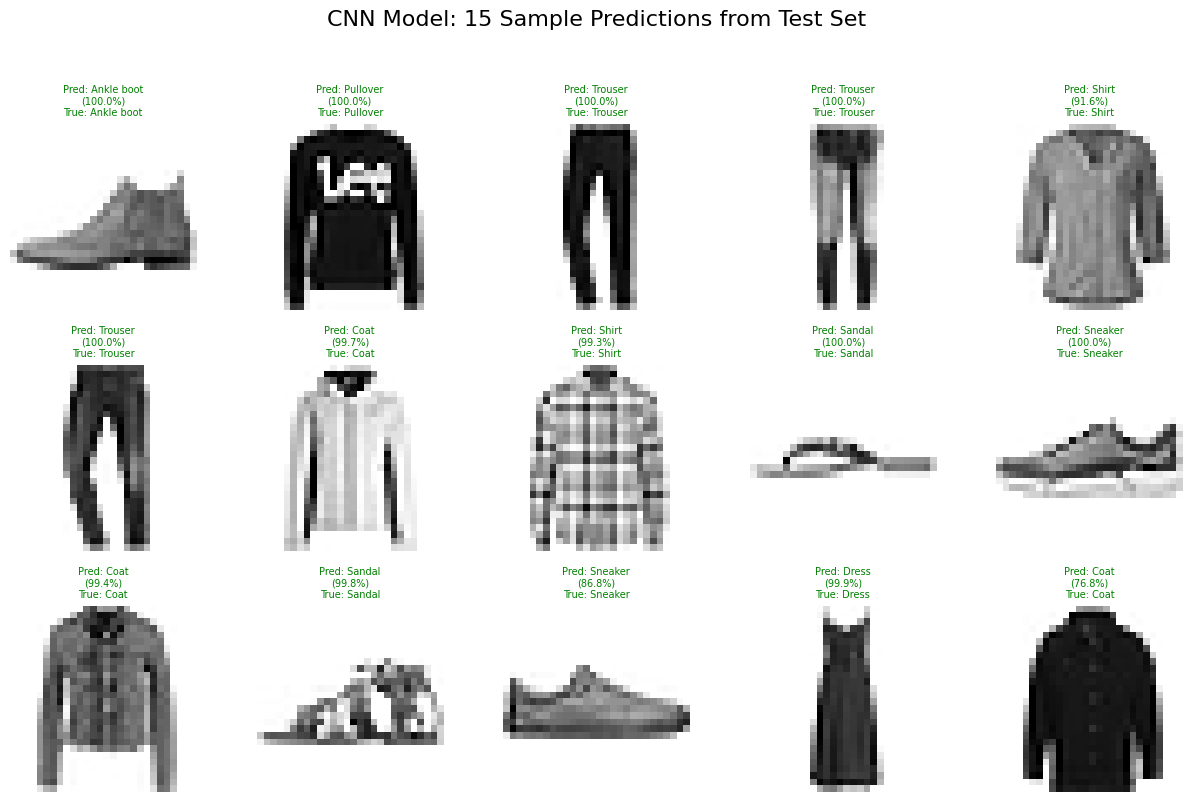

In [14]:
# CNN SAMPLE PREDICTIONS VISUALIZATION (in a single image)

print(f"\n Visualizing {NUM_SAMPLES_TO_SHOW} CNN Sample Predictions ")

# Determine grid size for subplots
rows = (NUM_SAMPLES_TO_SHOW + 4) // 5
cols = 5

# Layout Setup
plt.figure(figsize=(cols * 2.5, rows * 2.8))

for i in range(NUM_SAMPLES_TO_SHOW):
    plt.subplot(rows, cols, i + 1)

    input_sample = test_images_prepared[i:i+1]

    true_label_index = test_labels[i]
    true_label_name = CLASS_NAMES[true_label_index]

    # CNN Prediction
    cnn_pred_probs = cnn_model.predict(input_sample, verbose=0)[0]
    cnn_predicted_index = np.argmax(cnn_pred_probs)
    cnn_predicted_name = CLASS_NAMES[cnn_predicted_index]
    cnn_confidence = cnn_pred_probs[cnn_predicted_index] * 100

    # Display the image
    plt.imshow(test_images[i], cmap=plt.cm.binary)
    plt.axis('off')

    # Set title with prediction, confidence, and true label
    color = "green" if cnn_predicted_index == true_label_index else "red"
    title_text = f"Pred: {cnn_predicted_name}\n({cnn_confidence:.1f}%)\nTrue: {true_label_name}"

    plt.title(title_text, color=color, fontsize=7)

# Final Layout Adjustments
plt.suptitle(f'CNN Model: {NUM_SAMPLES_TO_SHOW} Sample Predictions from Test Set', fontsize=16)
plt.subplots_adjust(wspace=0.3, hspace=0.6)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#  ANN Misclassification Explorer  

This cell helps us **focus on the ANN’s mistakes**:

1. Finds all test-set indices where the ANN’s predicted label ≠ the true label.  
2. Prints how many total errors occurred and displays the **first N (10 by default)**.  
3. For each mis-hit it shows the image along with:  
   • Wrongly predicted class + confidence (%) — rendered in **red**  
   • The correct class label  

Use this gallery to spot systematic failure modes (e.g., confusing *Shirt* with *T-shirt/top*).

Displaying the first 10 misclassified items.


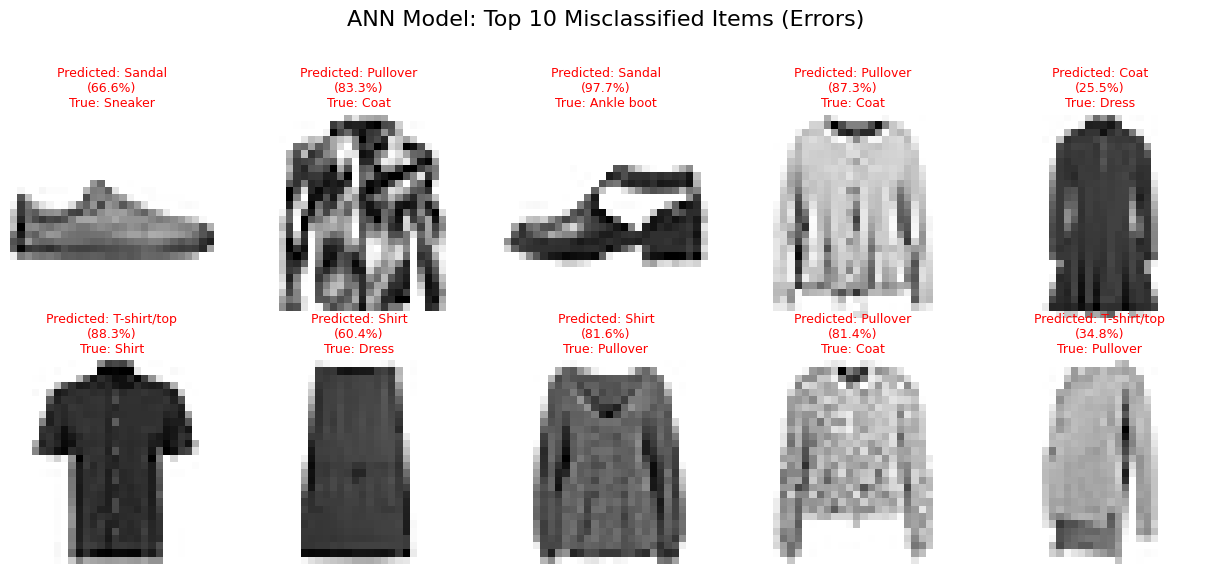

In [15]:
# ANN MISCLASSIFICATION VISUALIZATION

# Define the number of misclassified samples to show for visualization
NUM_MISCLASSIFICATIONS_TO_SHOW = 10 # You can change this number

# Find indices where predicted label does NOT match true label
misclassified_indices_ann = np.where(ann_predicted_labels != test_labels)[0]

# Calculate the total count BEFORE printing
total_misclassified_ann_count = len(misclassified_indices_ann)

# Print the requested output format
# Note: You need to re-run the full script or at least the setup sections (1-5)
# and the model loading to ensure ann_model and ann_predicted_labels exist.
print(f"Displaying the first {NUM_MISCLASSIFICATIONS_TO_SHOW} misclassified items.")

# Limit the list to the desired number of examples for visualization
display_indices_ann = misclassified_indices_ann[:NUM_MISCLASSIFICATIONS_TO_SHOW]

# Setup plot
rows = (NUM_MISCLASSIFICATIONS_TO_SHOW + 4) // 5
cols = 5
plt.figure(figsize=(cols * 2.5, rows * 3.0))
plt.suptitle(f'ANN Model: Top {len(display_indices_ann)} Misclassified Items (Errors)', fontsize=16)

for j, i in enumerate(display_indices_ann):
    plt.subplot(rows, cols, j + 1)

    # Get details
    true_label_name = CLASS_NAMES[test_labels[i]]
    predicted_label_name = CLASS_NAMES[ann_predicted_labels[i]]

    # Find confidence for the *predicted* (wrong) class
    prediction_confidence = ann_predictions[i, ann_predicted_labels[i]] * 100

    # Display the image
    plt.imshow(test_images[i], cmap=plt.cm.binary)
    plt.axis('off')

    # Set title: Red text indicates the error
    title_text = f"Predicted: {predicted_label_name}\n({prediction_confidence:.1f}%)\nTrue: {true_label_name}"
    plt.title(title_text, color='red', fontsize=9)

# Final Layout Adjustments
plt.subplots_adjust(wspace=0.3, hspace=0.6)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#  CNN Misclassification Explorer  

This cell zeroes-in on the **errors** made by the CNN:

1. Finds all test-set indices where the predicted label ≠ the true label.  
2. Displays the first *N* (10 by default) misclassified images in a grid.  
3. Each tile shows  
   • The **wrongly predicted class** + model confidence (%) – in **red**  
   • The **true class** label below it  

Great for quickly spotting systematic confusions (e.g., Shirt vs T-shirt/top).


 Visualizing 10 CNN Misclassified Samples 


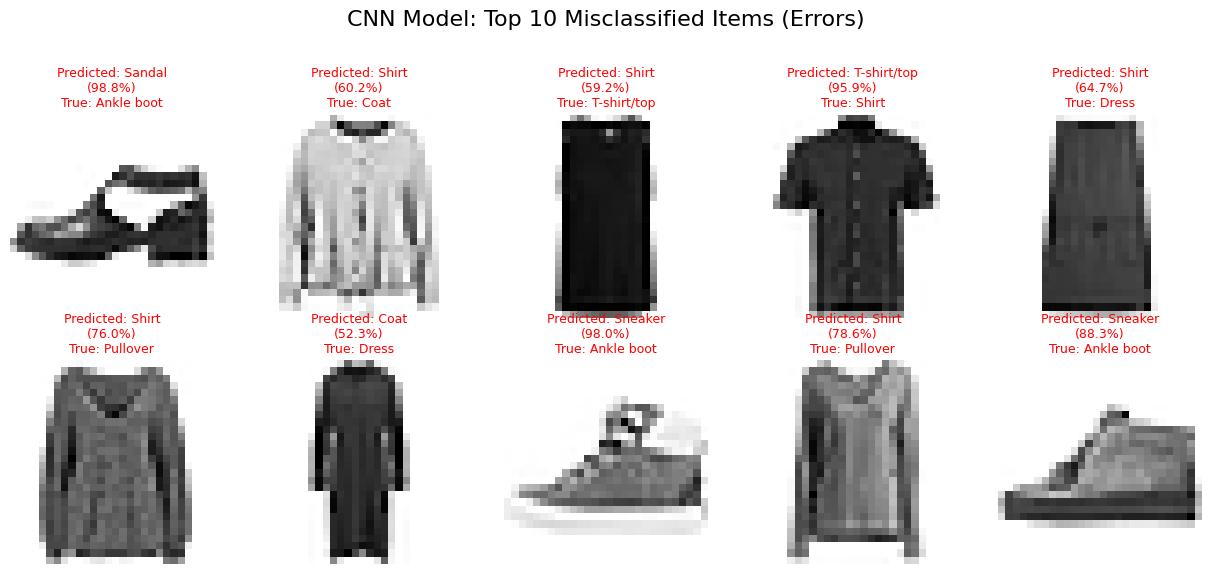

In [16]:
# CNN MISCLASSIFICATION VISUALIZATION

print(f"\n Visualizing {NUM_MISCLASSIFICATIONS_TO_SHOW} CNN Misclassified Samples ")

# Find indices where predicted label does NOT match true label
misclassified_indices = np.where(cnn_predicted_labels != test_labels)[0]

# Limit the list to the desired number of examples
display_indices = misclassified_indices[:NUM_MISCLASSIFICATIONS_TO_SHOW]

# Setup plot
rows = (NUM_MISCLASSIFICATIONS_TO_SHOW + 4) // 5
cols = 5
plt.figure(figsize=(cols * 2.5, rows * 3.0))
plt.suptitle(f'CNN Model: Top {len(display_indices)} Misclassified Items (Errors)', fontsize=16)

for j, i in enumerate(display_indices):
    plt.subplot(rows, cols, j + 1)

    # Get details
    true_label_name = CLASS_NAMES[test_labels[i]]
    predicted_label_name = CLASS_NAMES[cnn_predicted_labels[i]]

    # Find confidence for the *predicted* (wrong) class
    prediction_confidence = cnn_predictions[i, cnn_predicted_labels[i]] * 100

    # Display the image
    plt.imshow(test_images[i], cmap=plt.cm.binary)
    plt.axis('off')

    # Set title: Red text indicates the error
    title_text = f"Predicted: {predicted_label_name}\n({prediction_confidence:.1f}%)\nTrue: {true_label_name}"
    plt.title(title_text, color='red', fontsize=9)

# Final Layout Adjustments
plt.subplots_adjust(wspace=0.3, hspace=0.6)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#  Misclassification Summary Table  

This cell converts each model’s **test accuracy** into an absolute count of *errors* on the 10 000-image test set, then prints a tidy markdown-like table:

| Model | Test Accuracy | Misclassified Samples |
|-------|---------------|-----------------------|
| ANN   | …             | …                     |
| CNN   | …             | …                     |

A quick, human-readable scorecard to see how many items each network still gets wrong.

In [17]:
# Misclassification Calculation and Comparison
ann_misclassified_count = round(10000 * (1 - ann_accuracy))
cnn_misclassified_count = round(10000 * (1 - cnn_accuracy))

print("\n Model Misclassification Summary (Out of 10,000 Test Samples) ")
print(f"| {'Model':<5} | {'Test Accuracy':<15} | {'Misclassified Samples':<25} |")
print(f"| {'-'*5} | {'-'*15} | {'-'*25} |")
print(f"| {'ANN':<5} | {ann_accuracy:.4f} ({ann_accuracy*100:.2f}%) | {ann_misclassified_count:<25} |")
print(f"| {'CNN':<5} | {cnn_accuracy:.4f} ({cnn_accuracy*100:.2f}%) | {cnn_misclassified_count:<25} |")



 Model Misclassification Summary (Out of 10,000 Test Samples) 
| Model | Test Accuracy   | Misclassified Samples     |
| ----- | --------------- | ------------------------- |
| ANN   | 0.8754 (87.54%) | 1246                      |
| CNN   | 0.9089 (90.89%) | 911                       |


# Multi-Class ROC Curve Analysis for CNN Model (One-vs-Rest)  

This cell generates a comprehensive **ROC curve visualization** to evaluate the CNN’s performance across all 10 fashion classes:

1. **Binarizes true labels** for one-vs-rest classification.  
2. **Computes ROC curves & AUC** for:  
   - Each individual class (e.g., *T-shirt/top* vs rest)  
   - **Micro-average** (global FPR/TPR weighted by class support)  
   - **Macro-average** (unweighted mean of per-class curves)  
3. **Plots all curves** in one figure with:  
   - Dashed lines for individual classes  
   - Solid red line for macro-average  
   - Dotted blue line for micro-average  
   - Diagonal line for random chance (AUC=0.5)  
4. **Prints final AUC scores** for micro and macro averages.  

A high AUC (close to 1) indicates strong class separation capability!

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


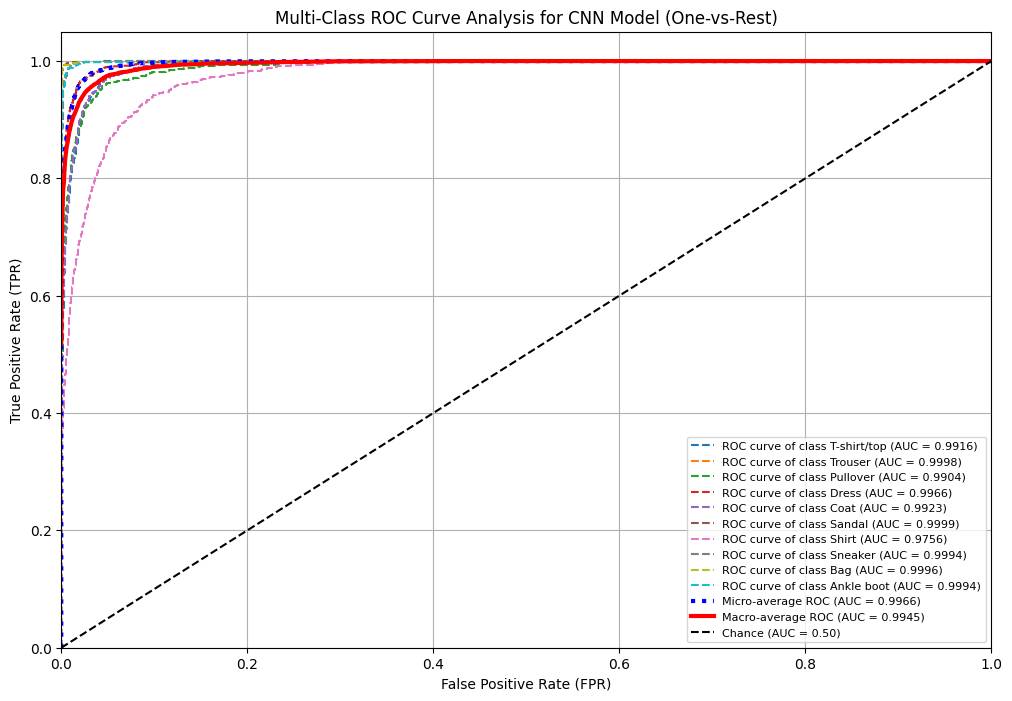


--- FINAL AUC SCORES ---
Micro-Average AUC: 0.9966
Macro-Average AUC: 0.9945


In [18]:
# PLOT RESULTS

# Define N_CLASSES
N_CLASSES = len(CLASS_NAMES)

# Calculate ROC curve and AUC for each class (One-vs-Rest)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize the true labels for multi-class ROC
y_true_binarized = label_binarize(test_labels, classes=range(N_CLASSES))

# Get predicted probabilities from the CNN model
cnn_pred_probs = cnn_model.predict(test_images_prepared)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(N_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], cnn_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_binarized.ravel(), cnn_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(N_CLASSES)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(N_CLASSES):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Average and compute AUC
mean_tpr /= N_CLASSES

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


plt.figure(figsize=(12, 8))

# Plot all individual class ROC curves
for i in range(N_CLASSES):
    plt.plot(fpr[i], tpr[i],
             label=f'ROC curve of class {CLASS_NAMES[i]} (AUC = {roc_auc[i]:.4f})',
             linestyle='--')

# Plot Micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='blue', linewidth=3, linestyle=':')

# Plot Macro-average ROC curve
plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average ROC (AUC = {roc_auc["macro"]:.4f})',
         color='red', linewidth=3, linestyle='-')


# Plot the baseline (random chance)
plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Multi-Class ROC Curve Analysis for CNN Model (One-vs-Rest)')
plt.legend(loc="lower right", fontsize=8)
plt.grid(True)
plt.show()

print("\n--- FINAL AUC SCORES ---")
print(f"Micro-Average AUC: {roc_auc['micro']:.4f}")
print(f"Macro-Average AUC: {roc_auc['macro']:.4f}")